In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
# Install Tensorflow first with pip: "pip install tensorflow --user"
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [3]:
data_dir = "D:\\FGW\\GDRIVE\\My BI\\Data"
csv_file = "TESLA_STOCK_2010_2020.csv"
csv_path = os.path.join(data_dir, csv_file)

In [4]:
stock_df = pd.read_csv(csv_path,  parse_dates = True, index_col=0)
#stock_df = pd.read_csv(csv_path,  parse_dates = True)

In [5]:
stock_df.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [6]:
stock_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
stock_df.index.name

'Date'

In [8]:
print('First observation date: %s \nLast observation date: %s' % (stock_df.index[0].date(), stock_df.index[-1].date()))

First observation date: 2010-06-29 
Last observation date: 2020-02-03


In [9]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj Close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


In [10]:
stock_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


<AxesSubplot:xlabel='Date'>

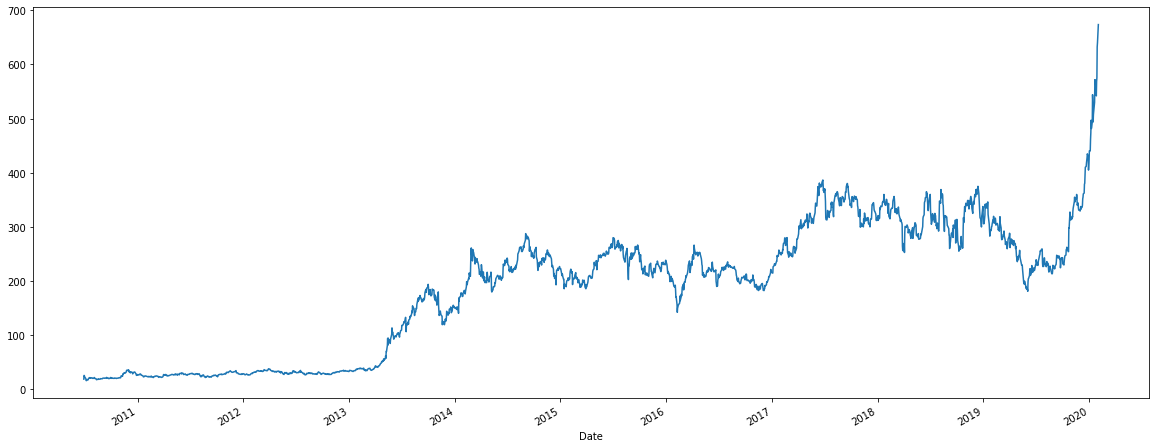

In [11]:
stock_df["Open"].plot(figsize=(20,8))

<AxesSubplot:xlabel='Date'>

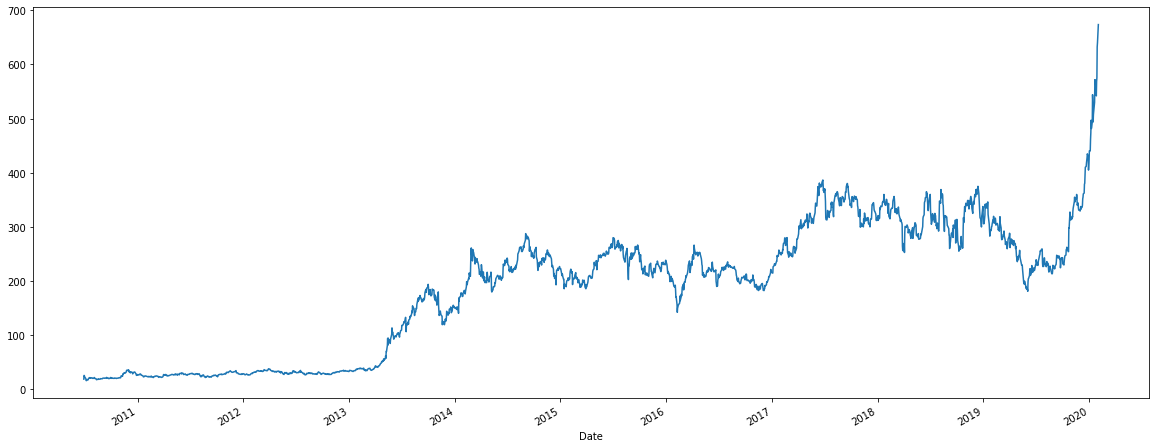

In [12]:
stock_df["Open"].plot(figsize=(20,8))

<AxesSubplot:xlabel='Date'>

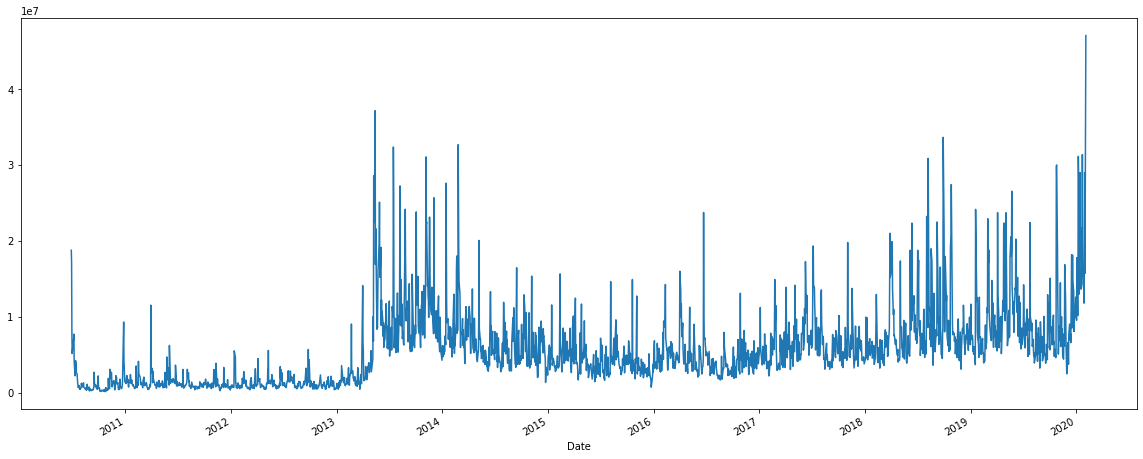

In [13]:
stock_df["Volume"].plot(figsize=(20,8))

In [14]:
stock_df.drop(['Adj Close'], inplace = True, axis = 1)
col_names = [name for name in stock_df.columns]

In [15]:
values = stock_df.values

num_cols = len(stock_df.columns)


In [16]:

'''
groups = [x for x in range(num_cols)]

plt.figure(figsize = (12,16))

i = 1
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(stock_df.columns[group], y=0.85, loc='center')
    i += 1
plt.show()
'''

"\ngroups = [x for x in range(num_cols)]\n\nplt.figure(figsize = (12,16))\n\ni = 1\nfor group in groups:\n    plt.subplot(len(groups), 1, i)\n    plt.plot(values[:, group])\n    plt.title(stock_df.columns[group], y=0.85, loc='center')\n    i += 1\nplt.show()\n"

In [17]:
# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [18]:
scaled

array([[0.00434948, 0.01087705, 0.00388739, 0.01058623, 0.39721385],
       [0.01467569, 0.0179205 , 0.01263401, 0.01050772, 0.36357558],
       [0.01347426, 0.01207262, 0.00803292, 0.00806071, 0.17254321],
       ...,
       [0.93723667, 0.82422584, 0.9156922 , 0.81786174, 0.6153217 ],
       [0.9487643 , 0.8269808 , 0.93774104, 0.8306333 , 0.3323102 ],
       [1.        , 1.        , 1.        , 0.99999994, 1.        ]],
      dtype=float32)

In [19]:
def dataset_gen(data, col_names, num_steps_in=1, num_steps_out=1):
    '''
    This function reformats the dataset the way it can be fed to the LSTM.
    '''
    
   
    df = pd.DataFrame(data)
    columns, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(num_steps_in, 0, -1):

        columns.append(df.shift(i))
        names += ['%s(t-%d)' % (n, i) for n in col_names]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_steps_out):
        columns.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % n) for n in col_names]
        else:
            names += [('%s(t+%d)' % (n, i)) for n in col_names]
   
    dataset = pd.concat(columns, axis=1)
    dataset.columns = names
    
    return dataset

In [20]:
num_steps_in = 6
num_steps_out = 1
n_features = num_cols
dataset = dataset_gen(scaled, col_names, num_steps_in, num_steps_out)

In [21]:
dataset

,Open(t-6),High(t-6),Low(t-6),Close(t-6),Volume(t-6),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume(t-5),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.004349,0.010877,0.003887,0.010586,0.397214
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.004349,0.010877,0.003887,0.010586,0.397214,0.014676,0.017920,0.012634,0.010508,0.363576
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014676,0.017920,0.012634,0.010508,0.363576,0.013474,0.012073,0.008033,0.008061,0.172543
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013474,0.012073,0.008033,0.008061,0.172543,0.010433,0.008408,0.005664,0.004449,0.106958
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.010433,0.008408,0.005664,0.004449,0.106958,0.005870,0.004379,0.001291,0.000406,0.143747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,0.747426,0.648517,0.741306,0.647344,0.287787,0.781857,0.691284,0.779649,0.695368,0.376705,...,0.799711,0.711895,0.796155,0.709526,0.287340,0.840012,0.727970,0.824703,0.721146,0.248581
2412,0.781857,0.691284,0.779649,0.695368,0.376705,0.845183,0.750958,0.826252,0.724627,0.665662,...,0.840012,0.727970,0.824703,0.721146,0.248581,0.850962,0.744851,0.838901,0.739584,0.376663
2413,0.845183,0.750958,0.826252,0.724627,0.665662,0.833564,0.734714,0.820937,0.728082,0.416059,...,0.850962,0.744851,0.838901,0.739584,0.376663,0.937237,0.824226,0.915692,0.817862,0.615322
2414,0.833564,0.734714,0.820937,0.728082,0.416059,0.843267,0.724136,0.818902,0.718424,0.303220,...,0.937237,0.824226,0.915692,0.817862,0.615322,0.948764,0.826981,0.937741,0.830633,0.332310


In [22]:
dataset.dropna(inplace=True)

In [23]:
dataset

,Open(t-6),High(t-6),Low(t-6),Close(t-6),Volume(t-6),Open(t-5),High(t-5),Low(t-5),Close(t-5),Volume(t-5),...,Open(t-1),High(t-1),Low(t-1),Close(t-1),Volume(t-1),Open(t),High(t),Low(t),Close(t),Volume(t)
6,0.004349,0.010877,0.003887,0.010586,0.397214,0.014676,0.017920,0.012634,0.010508,0.363576,...,0.000395,0.000000,0.000000,0.000000,0.144914,0.000000,0.001157,0.000896,0.002172,0.161735
7,0.014676,0.017920,0.012634,0.010508,0.363576,0.013474,0.012073,0.008033,0.008061,0.172543,...,0.000000,0.001157,0.000896,0.002172,0.161735,0.002190,0.001650,0.002384,0.002094,0.083757
8,0.013474,0.012073,0.008033,0.008061,0.172543,0.010433,0.008408,0.005664,0.004449,0.106958,...,0.002190,0.001650,0.002384,0.002094,0.083757,0.002753,0.001871,0.003067,0.001636,0.044391
9,0.010433,0.008408,0.005664,0.004449,0.106958,0.005870,0.004379,0.001291,0.000406,0.143747,...,0.002753,0.001871,0.003067,0.001636,0.044391,0.001901,0.002612,0.002916,0.003062,0.054564
10,0.005870,0.004379,0.001291,0.000406,0.143747,0.000395,0.000000,0.000000,0.000000,0.144914,...,0.001901,0.002612,0.002916,0.003062,0.054564,0.002737,0.004574,0.004221,0.005287,0.086837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2411,0.747426,0.648517,0.741306,0.647344,0.287787,0.781857,0.691284,0.779649,0.695368,0.376705,...,0.799711,0.711895,0.796155,0.709526,0.287340,0.840012,0.727970,0.824703,0.721146,0.248581
2412,0.781857,0.691284,0.779649,0.695368,0.376705,0.845183,0.750958,0.826252,0.724627,0.665662,...,0.840012,0.727970,0.824703,0.721146,0.248581,0.850962,0.744851,0.838901,0.739584,0.376663
2413,0.845183,0.750958,0.826252,0.724627,0.665662,0.833564,0.734714,0.820937,0.728082,0.416059,...,0.850962,0.744851,0.838901,0.739584,0.376663,0.937237,0.824226,0.915692,0.817862,0.615322
2414,0.833564,0.734714,0.820937,0.728082,0.416059,0.843267,0.724136,0.818902,0.718424,0.303220,...,0.937237,0.824226,0.915692,0.817862,0.615322,0.948764,0.826981,0.937741,0.830633,0.332310


In [24]:
# split into dataset into train and test sets with scale 80:20
values = dataset.values
train_size = int(len(values) * 0.8)
test_size = len(values) - train_size
train = values[0:train_size]
test = values[train_size:len(values)]
print(len(train), len(test))

1928 482


In [25]:
num_col_input = num_steps_in*num_cols

In [26]:
num_col_target = num_steps_out*num_cols

In [27]:
target_idx = [dataset.columns.to_list().index(col) for col in dataset.columns[num_col_input:] if 'Open' in col]

In [28]:
target_idx = [dataset.columns.to_list().index(col) for col in dataset.columns[num_col_input:] if 'Open' in col]

In [29]:
train.shape

(1928, 35)

In [30]:
train_X, train_y = train[:, :num_col_input], train[:, target_idx]
test_X, test_y = test[:, :num_col_input], test[:, target_idx]

# reshape input to fit the LSTM network requirements: [n_samples, window, n_features]
train_X = train_X.reshape((train_X.shape[0], num_steps_in, n_features))
test_X = test_X.reshape((test_X.shape[0], num_steps_in, n_features))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1928, 6, 5) (1928, 1) (482, 6, 5) (482, 1)


In [31]:
train_X[0]

array([[4.34947945e-03, 1.08770542e-02, 3.88738886e-03, 1.05862319e-02,
        3.97213846e-01],
       [1.46756917e-02, 1.79204978e-02, 1.26340073e-02, 1.05077196e-02,
        3.63575578e-01],
       [1.34742595e-02, 1.20726191e-02, 8.03292170e-03, 8.06071423e-03,
        1.72543213e-01],
       [1.04326680e-02, 8.40795040e-03, 5.66404313e-03, 4.44909744e-03,
        1.06957912e-01],
       [5.87027520e-03, 4.37941216e-03, 1.29073299e-03, 4.05652449e-04,
        1.43746600e-01],
       [3.95406038e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.44913882e-01]], dtype=float32)

In [32]:
# Create an model for LSMT RNN
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(train_y.shape[1]))

model.compile(loss='mean_squared_error', optimizer='adam')

t = model.fit(train_X, train_y, epochs=50,
              batch_size=32,
              validation_data=(test_X, test_y),
              verbose=1,
              shuffle=False)


Epoch 1/50
61/61 [==============================] - 4s 22ms/step - loss: 4.7794e-04 - val_loss: 7.5711e-04
Epoch 2/50
61/61 [==============================] - 1s 9ms/step - loss: 3.5663e-04 - val_loss: 6.0551e-04
Epoch 3/50
61/61 [==============================] - 1s 9ms/step - loss: 1.3105e-04 - val_loss: 4.7250e-04
Epoch 4/50
61/61 [==============================] - 1s 9ms/step - loss: 1.1680e-04 - val_loss: 4.5278e-04
Epoch 5/50
61/61 [==============================] - 1s 9ms/step - loss: 1.2549e-04 - val_loss: 4.4659e-04
Epoch 6/50
61/61 [==============================] - 1s 9ms/step - loss: 1.2424e-04 - val_loss: 4.3741e-04
Epoch 7/50
61/61 [==============================] - 1s 9ms/step - loss: 1.1961e-04 - val_loss: 4.2699e-04
Epoch 8/50
61/61 [==============================] - 1s 9ms/step - loss: 1.1411e-04 - val_loss: 4.1618e-04
Epoch 9/50
61/61 [==============================] - 1s 10ms/step - loss: 1.0958e-04 - val_loss: 4.0428e-04
Epoch 10/50
61/61 [=========================

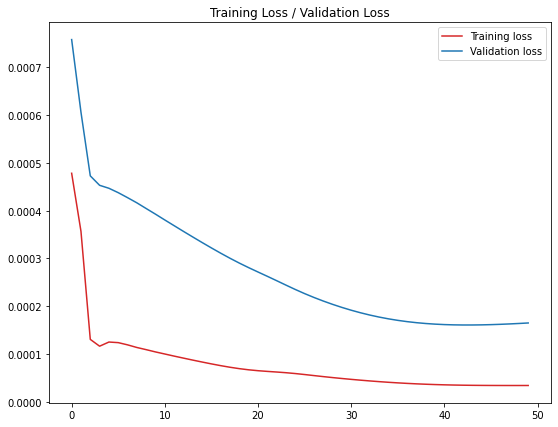

In [33]:
# plot training history
plt.figure(figsize = (9,7))
plt.title('Training Loss / Validation Loss')
plt.plot(t.history['loss'], 'tab:red', label='Training loss')
plt.plot(t.history['val_loss'], 'tab:blue', label='Validation loss')
plt.legend()
plt.show()

In [34]:
# Try a prediction with Test data
y_predict = model.predict(test_X)

# invert scaling
y_predict_inv = y_predict / scaler.scale_[0]
y_inv = test_y / scaler.scale_[0]

# reshape back
y_predict_inv_rshp = y_predict_inv.reshape((-1,1))
y_inv_rshp = y_inv.reshape((-1,1))

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(y_inv_rshp, y_predict_inv_rshp))
print('Test set RMSE: %.2f' % rmse)



Test set RMSE: 8.45


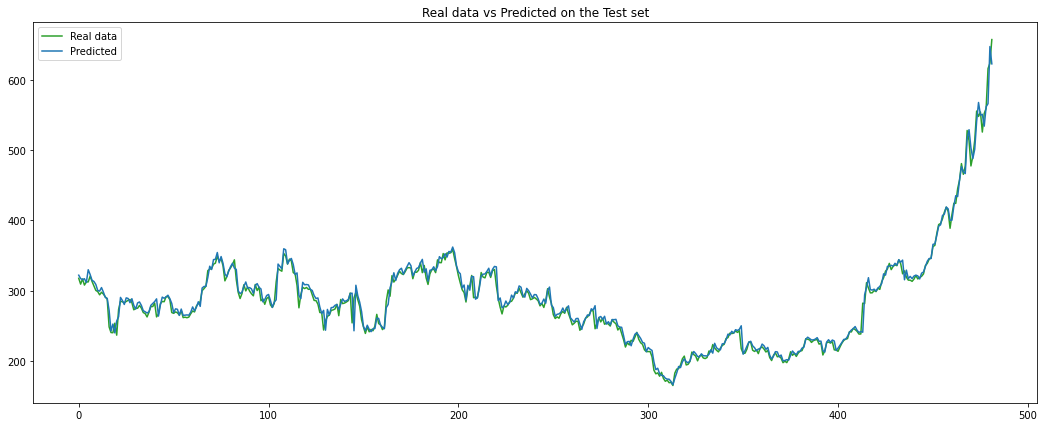

In [35]:
plt.figure(figsize = (18,7))
plt.title('Real data vs Predicted on the Test set')
plt.plot(y_inv_rshp, 'tab:green', label='Real data')
plt.plot(y_predict_inv_rshp, 'tab:blue', label='Predicted')
plt.legend()
plt.show()

In [36]:
error = (y_predict_inv_rshp - y_inv_rshp)
average_error = error.sum()/len(y_inv_rshp)
print("Average Error: %.2f" %average_error)

Average Error: 2.61


In [37]:
print("Max Error: %.2f" %error.max())

Max Error: 42.38
